# Determine Correlation between Technical and Fundamental

This notebook is to download the required data from yfinance once for all the interested tickers. Once we have the data, we no longer need to keep going out to the internet and request more data, reducing network load

In [1]:
s_ticker = "C"

In [2]:

import json

def load_quarterly_fundamentals(ticker):
    """Load quarterly fundamentals from saved file"""
    
    filename = f'fundamentals/{ticker}_quarterly_key_metrics.json'
    
    try:
        with open(filename, 'r') as f:
            quarterly_data = json.load(f)
        return quarterly_data
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return {}
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return {}

# Load quarterly data for current ticker
quarterly_data = load_quarterly_fundamentals(s_ticker)

print(f"Loaded quarterly fundamentals for {s_ticker}")
print("\nQuarterly Key Metrics:")
for quarter, data in quarterly_data.items():
    print(f"\n{quarter}:")
    if data['income_statement']['total_revenue']:
        print(f"  Revenue: ${float(data['income_statement']['total_revenue']):,.0f}")
    if data['income_statement']['net_income']:
        print(f"  Net Income: ${float(data['income_statement']['net_income']):,.0f}")
    if data['income_statement']['diluted_eps']:
        print(f"  EPS: ${float(data['income_statement']['diluted_eps']):.2f}")

Loaded quarterly fundamentals for C

Quarterly Key Metrics:

2025-03-31:
  Revenue: $21,601,000,000
  Net Income: $4,064,000,000
  EPS: $1.96

2024-12-31:
  Revenue: $19,586,000,000
  Net Income: $2,856,000,000
  EPS: $1.34

2024-09-30:
  Revenue: $20,265,000,000
  Net Income: $3,238,000,000
  EPS: $1.51

2024-06-30:
  Revenue: $20,144,000,000
  Net Income: $3,217,000,000
  EPS: $1.52

2024-03-31:
  Revenue: $21,006,000,000
  Net Income: $3,371,000,000
  EPS: $1.58


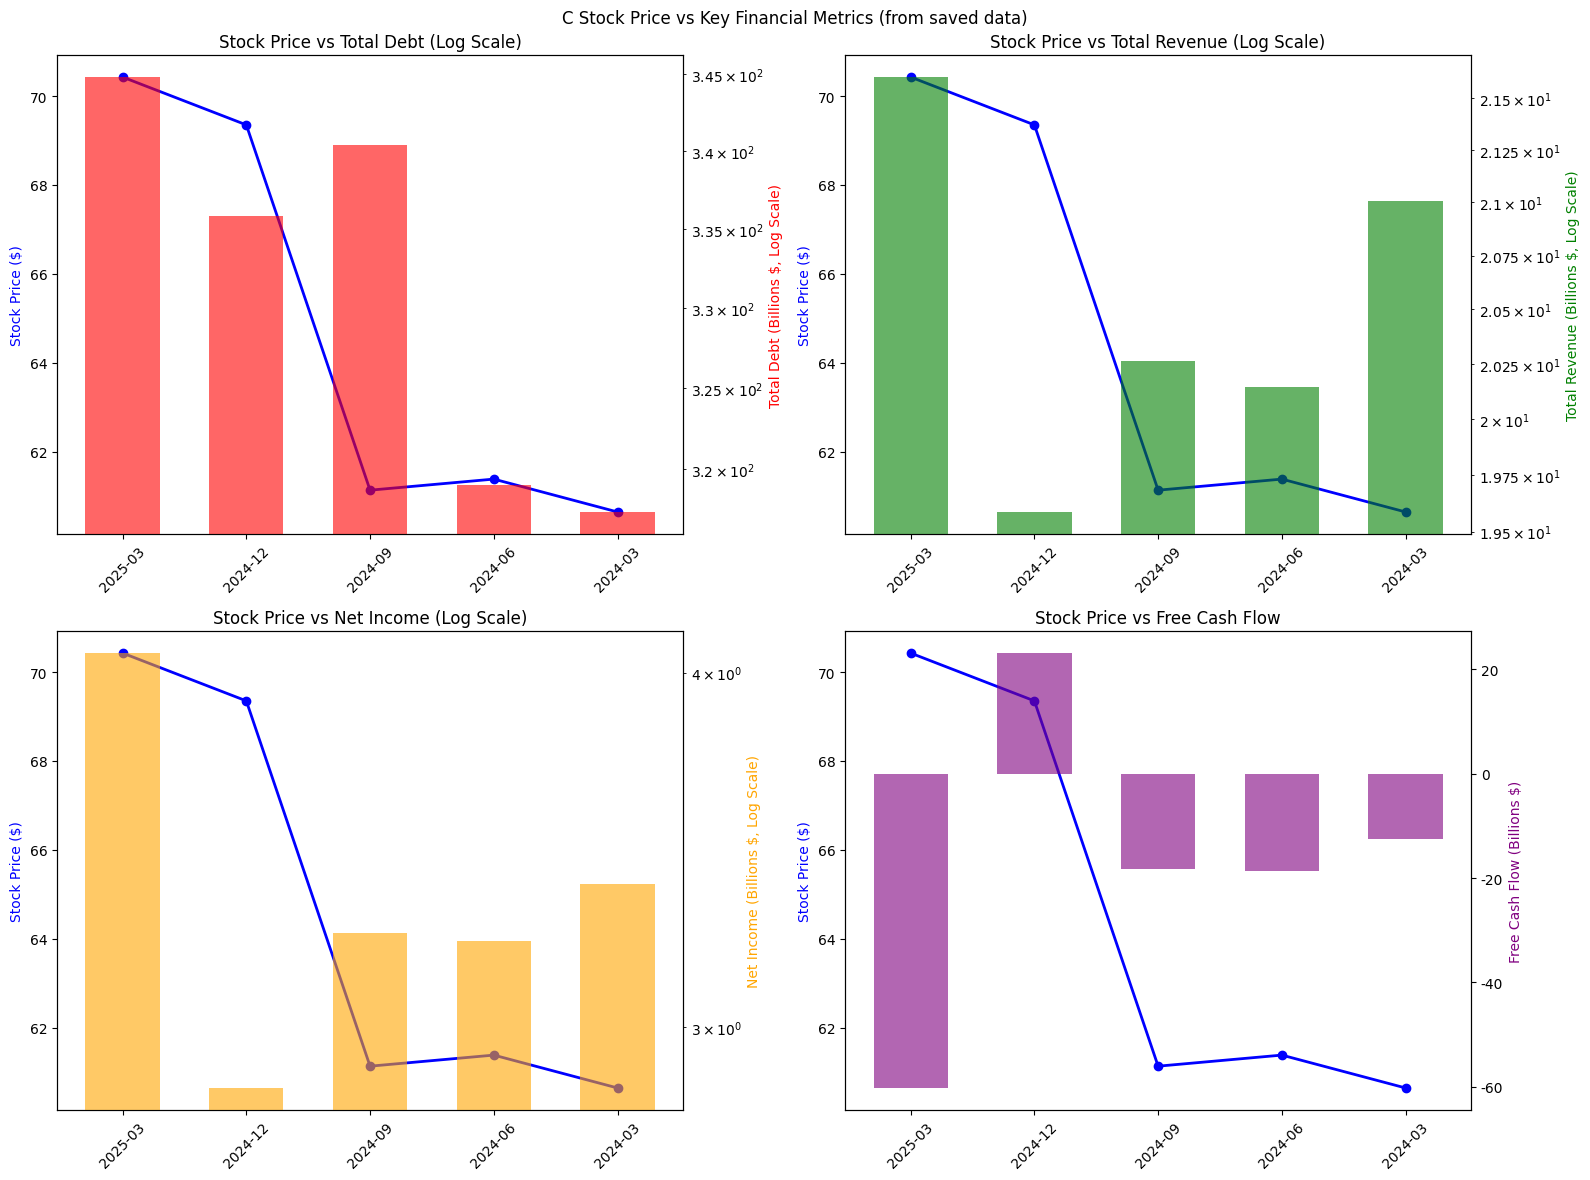

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Load stock data for current ticker
df = pd.read_csv(f'data/{s_ticker}_stock_data.csv', index_col=0, parse_dates=True)

# Load quarterly data from file
quarterly_data = load_quarterly_fundamentals(s_ticker)

# Extract data for plotting
quarter_dates = []
quarterly_prices = []
debt_values = []
revenue_values = []
income_values = []
fcf_values = []

for quarter, data in quarterly_data.items():
   # Convert quarter string to datetime for stock price lookup
   quarter_date = pd.to_datetime(quarter)
   quarter_dates.append(quarter_date)
   
   # Get stock price closest to quarter end
   closest_price = df[df.index <= quarter_date]['Close'].iloc[0] if len(df[df.index <= quarter_date]) > 0 else None
   quarterly_prices.append(closest_price)
   
   # Extract fundamental data (convert to billions)
   debt = data['balance_sheet']['total_debt']
   debt_values.append(float(debt) / 1e9 if debt else 0)
   
   revenue = data['income_statement']['total_revenue']
   revenue_values.append(float(revenue) / 1e9 if revenue else 0)
   
   income = data['income_statement']['net_income']
   income_values.append(float(income) / 1e9 if income else 0)
   
   fcf = data['cash_flow']['free_cash_flow']
   fcf_values.append(float(fcf) / 1e9 if fcf else 0)

# Create quarter labels
quarter_labels = [d.strftime('%Y-%m') for d in quarter_dates]

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total Debt - LOG SCALE
ax1 = axes[0,0]
ax2 = ax1.twinx()
ax1.plot(quarter_labels, quarterly_prices, 'b-o', linewidth=2, markersize=6)
ax1.set_ylabel('Stock Price ($)', color='blue')
ax2.bar(quarter_labels, debt_values, alpha=0.6, color='red', width=0.6)
ax2.set_ylabel('Total Debt (Billions $, Log Scale)', color='red')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
ax1.set_title('Stock Price vs Total Debt (Log Scale)')
ax1.tick_params(axis='x', rotation=45)

# Total Revenue - LOG SCALE
ax1 = axes[0,1]
ax2 = ax1.twinx()
ax1.plot(quarter_labels, quarterly_prices, 'b-o', linewidth=2, markersize=6)
ax1.set_ylabel('Stock Price ($)', color='blue')
ax2.bar(quarter_labels, revenue_values, alpha=0.6, color='green', width=0.6)
ax2.set_ylabel('Total Revenue (Billions $, Log Scale)', color='green')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
ax1.set_title('Stock Price vs Total Revenue (Log Scale)')
ax1.tick_params(axis='x', rotation=45)

# Net Income - LOG SCALE
ax1 = axes[1,0]
ax2 = ax1.twinx()
ax1.plot(quarter_labels, quarterly_prices, 'b-o', linewidth=2, markersize=6)
ax1.set_ylabel('Stock Price ($)', color='blue')
ax2.bar(quarter_labels, income_values, alpha=0.6, color='orange', width=0.6)
ax2.set_ylabel('Net Income (Billions $, Log Scale)', color='orange')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
ax1.set_title('Stock Price vs Net Income (Log Scale)')
ax1.tick_params(axis='x', rotation=45)

# Free Cash Flow
ax1 = axes[1,1]
ax2 = ax1.twinx()
ax1.plot(quarter_labels, quarterly_prices, 'b-o', linewidth=2, markersize=6)
ax1.set_ylabel('Stock Price ($)', color='blue')
ax2.bar(quarter_labels, fcf_values, alpha=0.6, color='purple', width=0.6)
ax2.set_ylabel('Free Cash Flow (Billions $)', color='purple')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
ax1.set_title('Stock Price vs Free Cash Flow')
ax1.tick_params(axis='x', rotation=45)

plt.suptitle(f'{s_ticker} Stock Price vs Key Financial Metrics (from saved data)')
plt.tight_layout()
plt.savefig(f'results/{s_ticker}_price_vs_all_fundamentals_debt_log.png', dpi=300, bbox_inches='tight')
plt.show()

## Technicals vs Fundamentals 

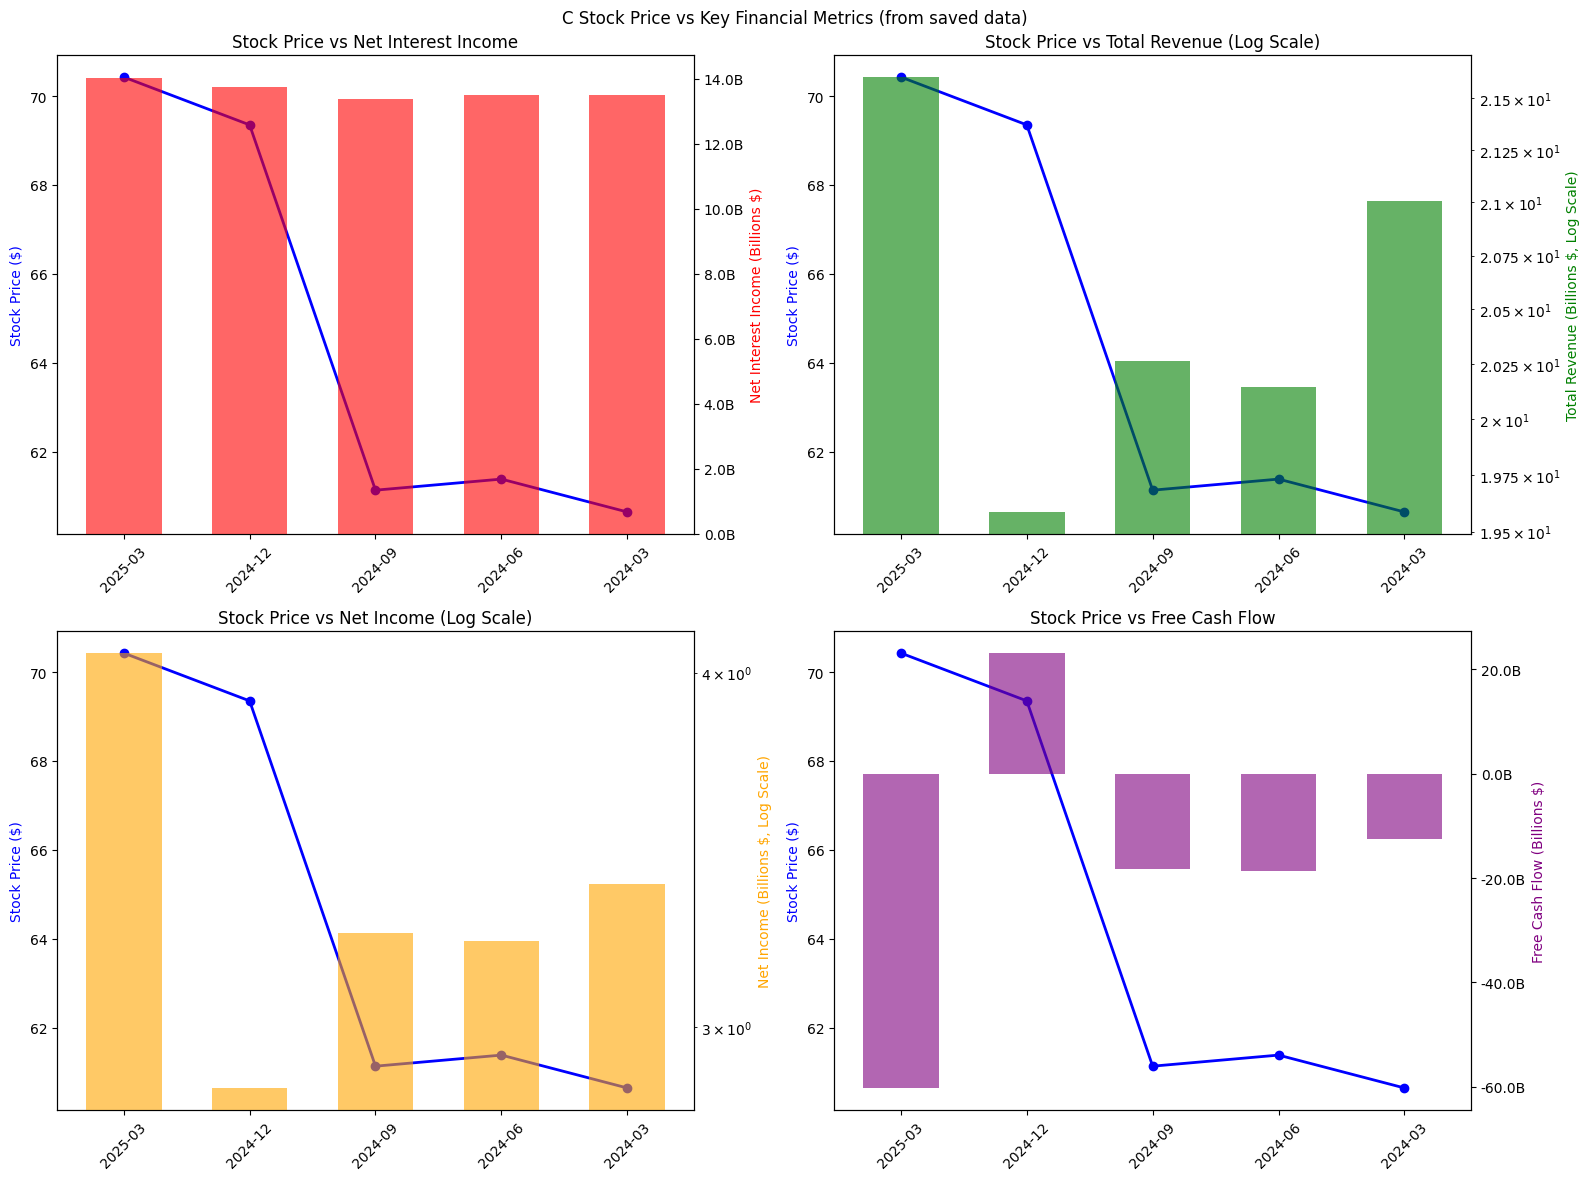

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Load stock data for current ticker
df = pd.read_csv(f'data/{s_ticker}_stock_data.csv', index_col=0, parse_dates=True)

# Load quarterly data from file
quarterly_data = load_quarterly_fundamentals(s_ticker)

# Extract data for plotting
quarter_dates = []
quarterly_prices = []
nii_values = []
revenue_values = []
income_values = []
fcf_values = []

for quarter, data in quarterly_data.items():
   # Convert quarter string to datetime for stock price lookup
   quarter_date = pd.to_datetime(quarter)
   quarter_dates.append(quarter_date)
   
   # Get stock price closest to quarter end
   closest_price = df[df.index <= quarter_date]['Close'].iloc[0] if len(df[df.index <= quarter_date]) > 0 else None
   quarterly_prices.append(closest_price)
   
   # Extract fundamental data (convert to billions)
   nii = data['income_statement']['net_interest_income']
   nii_values.append(float(nii) / 1e9 if nii else 0)
   
   revenue = data['income_statement']['total_revenue']
   revenue_values.append(float(revenue) / 1e9 if revenue else 0)
   
   income = data['income_statement']['net_income']
   income_values.append(float(income) / 1e9 if income else 0)
   
   fcf = data['cash_flow']['free_cash_flow']
   fcf_values.append(float(fcf) / 1e9 if fcf else 0)

# Create quarter labels
quarter_labels = [d.strftime('%Y-%m') for d in quarter_dates]

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Net Interest Income
ax1 = axes[0,0]
ax2 = ax1.twinx()
ax1.plot(quarter_labels, quarterly_prices, 'b-o', linewidth=2, markersize=6)
ax1.set_ylabel('Stock Price ($)', color='blue')
ax2.bar(quarter_labels, nii_values, alpha=0.6, color='red', width=0.6)
ax2.set_ylabel('Net Interest Income (Billions $)', color='red')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}B'))
ax1.set_title('Stock Price vs Net Interest Income')
ax1.tick_params(axis='x', rotation=45)

# Total Revenue - LOG SCALE
ax1 = axes[0,1]
ax2 = ax1.twinx()
ax1.plot(quarter_labels, quarterly_prices, 'b-o', linewidth=2, markersize=6)
ax1.set_ylabel('Stock Price ($)', color='blue')
ax2.bar(quarter_labels, revenue_values, alpha=0.6, color='green', width=0.6)
ax2.set_ylabel('Total Revenue (Billions $, Log Scale)', color='green')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}B'))
ax1.set_title('Stock Price vs Total Revenue (Log Scale)')
ax1.tick_params(axis='x', rotation=45)

# Net Income - LOG SCALE
ax1 = axes[1,0]
ax2 = ax1.twinx()
ax1.plot(quarter_labels, quarterly_prices, 'b-o', linewidth=2, markersize=6)
ax1.set_ylabel('Stock Price ($)', color='blue')
ax2.bar(quarter_labels, income_values, alpha=0.6, color='orange', width=0.6)
ax2.set_ylabel('Net Income (Billions $, Log Scale)', color='orange')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}B'))
ax1.set_title('Stock Price vs Net Income (Log Scale)')
ax1.tick_params(axis='x', rotation=45)

# Free Cash Flow
ax1 = axes[1,1]
ax2 = ax1.twinx()
ax1.plot(quarter_labels, quarterly_prices, 'b-o', linewidth=2, markersize=6)
ax1.set_ylabel('Stock Price ($)', color='blue')
ax2.bar(quarter_labels, fcf_values, alpha=0.6, color='purple', width=0.6)
ax2.set_ylabel('Free Cash Flow (Billions $)', color='purple')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}B'))
ax1.set_title('Stock Price vs Free Cash Flow')
ax1.tick_params(axis='x', rotation=45)

plt.suptitle(f'{s_ticker} Stock Price vs Key Financial Metrics (from saved data)')
plt.tight_layout()
plt.savefig(f'results/{s_ticker}_price_vs_all_fundamentals_log.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


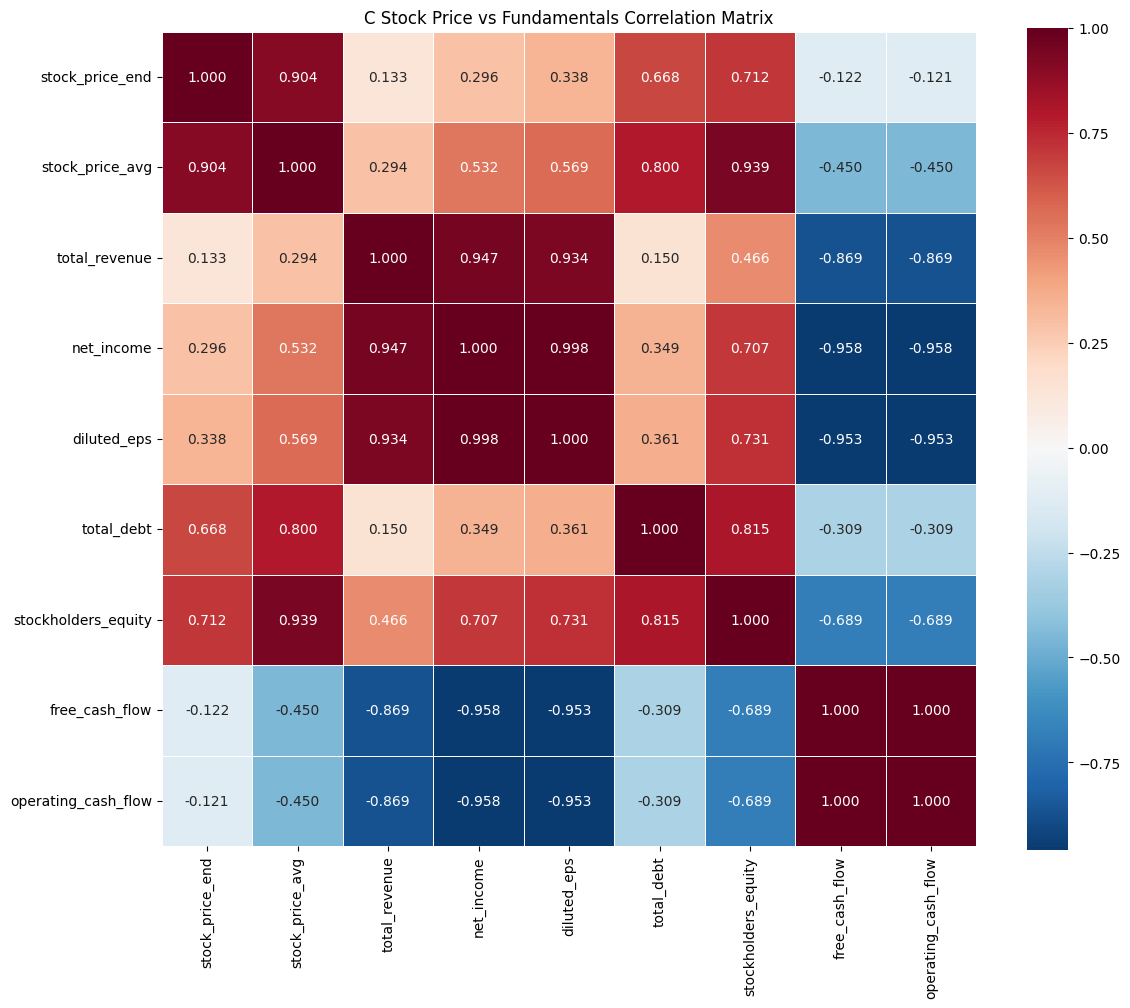


Correlations with Stock Price (End of Quarter):
stock_price_avg: 0.904
stockholders_equity: 0.712
total_debt: 0.668
diluted_eps: 0.338
net_income: 0.296
total_revenue: 0.133
operating_cash_flow: -0.121
free_cash_flow: -0.122


In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

def load_quarterly_fundamentals(ticker):
   """Load quarterly fundamentals from saved file"""
   
   filename = f'fundamentals/{ticker}_quarterly_key_metrics.json'
   
   try:
       with open(filename, 'r') as f:
           quarterly_data = json.load(f)
       return quarterly_data
   except FileNotFoundError:
       print(f"File not found: {filename}")
       return {}
   except Exception as e:
       print(f"Error loading {filename}: {e}")
       return {}

def create_correlation_dataset(ticker):
   """Create aligned dataset for correlation analysis"""
   
   # Load stock data
   stock_df = pd.read_csv(f'data/{ticker}_stock_data.csv', index_col=0, parse_dates=True)
   
   # Load quarterly fundamentals
   quarterly_data = load_quarterly_fundamentals(ticker)
   
   # Create correlation dataset
   correlation_data = []
   
   for quarter, data in quarterly_data.items():
       quarter_date = pd.to_datetime(quarter)
       
       # Get stock price at quarter end
       stock_price = stock_df[stock_df.index <= quarter_date]['Close'].iloc[0] if len(stock_df[stock_df.index <= quarter_date]) > 0 else None
       
       # Get average stock price for the quarter (3 months before quarter end)
       quarter_start = quarter_date - pd.DateOffset(months=3)
       quarter_prices = stock_df[(stock_df.index >= quarter_start) & (stock_df.index <= quarter_date)]['Close']
       avg_stock_price = quarter_prices.mean() if len(quarter_prices) > 0 else None
       
       if stock_price and avg_stock_price:
           row = {
               'quarter': quarter,
               'stock_price_end': stock_price,
               'stock_price_avg': avg_stock_price,
               'total_revenue': float(data['income_statement']['total_revenue']) / 1e9 if data['income_statement']['total_revenue'] else None,
               'net_income': float(data['income_statement']['net_income']) / 1e9 if data['income_statement']['net_income'] else None,
               'diluted_eps': float(data['income_statement']['diluted_eps']) if data['income_statement']['diluted_eps'] else None,
               'total_debt': float(data['balance_sheet']['total_debt']) / 1e9 if data['balance_sheet']['total_debt'] else None,
               'stockholders_equity': float(data['balance_sheet']['stockholders_equity']) / 1e9 if data['balance_sheet']['stockholders_equity'] else None,
               'free_cash_flow': float(data['cash_flow']['free_cash_flow']) / 1e9 if data['cash_flow']['free_cash_flow'] else None,
               'operating_cash_flow': float(data['cash_flow']['operating_cash_flow']) / 1e9 if data['cash_flow']['operating_cash_flow'] else None
           }
           correlation_data.append(row)
   
   return pd.DataFrame(correlation_data)

# Create correlation dataset
corr_df = create_correlation_dataset(s_ticker)

# Remove rows with missing values
corr_df_clean = corr_df.dropna()

# Select numeric columns for correlation
numeric_cols = ['stock_price_end', 'stock_price_avg', 'total_revenue', 'net_income', 
               'diluted_eps', 'total_debt', 'stockholders_equity', 'free_cash_flow', 
               'operating_cash_flow']

correlation_matrix = corr_df_clean[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
           square=True, linewidths=0.5, fmt='.3f')
plt.title(f'{s_ticker} Stock Price vs Fundamentals Correlation Matrix')
plt.tight_layout()
plt.savefig(f'results/{s_ticker}_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Show correlation with stock price specifically
print(f"\nCorrelations with Stock Price (End of Quarter):")
price_correlations = correlation_matrix['stock_price_end'].sort_values(ascending=False)
for metric, corr in price_correlations.items():
   if metric != 'stock_price_end':
       print(f"{metric}: {corr:.3f}")

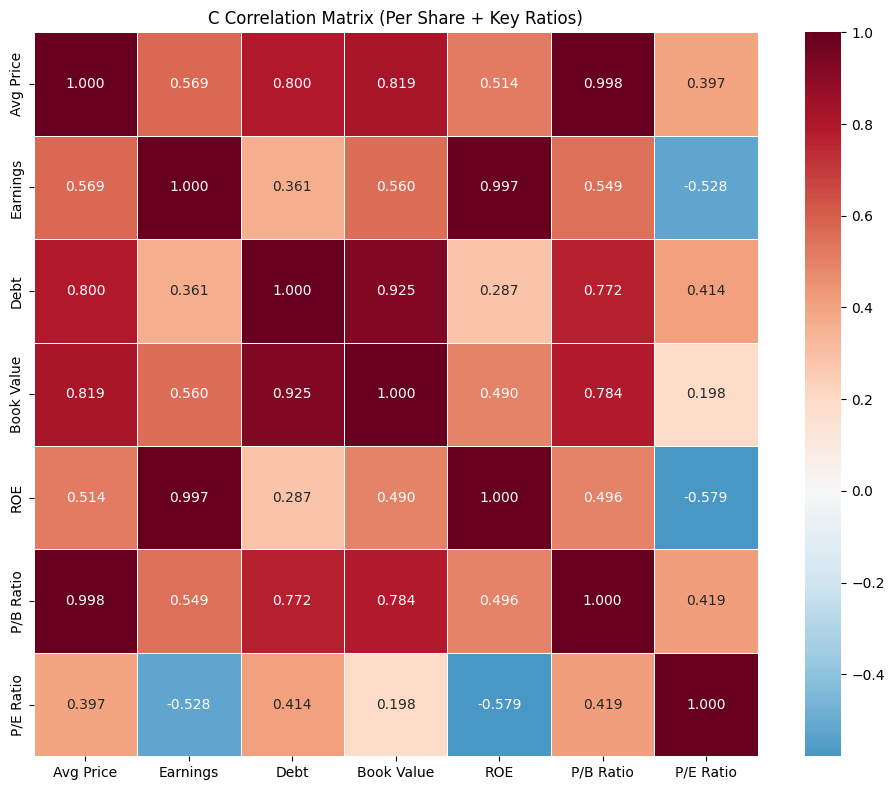


Correlations with Average Stock Price:
P/B Ratio: 0.998
Book Value: 0.819
Debt: 0.800
Earnings: 0.569
ROE: 0.514
P/E Ratio: 0.397


In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

def load_quarterly_fundamentals(ticker):
   """Load quarterly fundamentals from saved file"""
   
   filename = f'fundamentals/{ticker}_quarterly_key_metrics.json'
   
   try:
       with open(filename, 'r') as f:
           quarterly_data = json.load(f)
       return quarterly_data
   except FileNotFoundError:
       print(f"File not found: {filename}")
       return {}
   except Exception as e:
       print(f"Error loading {filename}: {e}")
       return {}

def create_correlation_dataset(ticker):
   """Create aligned dataset for correlation analysis"""
   
   # Load stock data
   stock_df = pd.read_csv(f'data/{ticker}_stock_data.csv', index_col=0, parse_dates=True)
   
   # Load quarterly fundamentals
   quarterly_data = load_quarterly_fundamentals(ticker)
   
   # Load key info to get shares outstanding
   with open(f'fundamentals/{ticker}_key_info.json', 'r') as f:
       key_info = json.load(f)
   
   shares_outstanding = float(key_info['valuation']['marketCap']) / float(key_info['valuation']['currentPrice']) if key_info['valuation']['marketCap'] and key_info['valuation']['currentPrice'] else None
   
   # Create correlation dataset
   correlation_data = []
   
   for quarter, data in quarterly_data.items():
       quarter_date = pd.to_datetime(quarter)
       
       # Get average stock price for the quarter (3 months before quarter end)
       quarter_start = quarter_date - pd.DateOffset(months=3)
       quarter_prices = stock_df[(stock_df.index >= quarter_start) & (stock_df.index <= quarter_date)]['Close']
       avg_stock_price = quarter_prices.mean() if len(quarter_prices) > 0 else None
       
       if avg_stock_price and shares_outstanding:
           # Calculate per share metrics
           total_debt_billions = float(data['balance_sheet']['total_debt']) / 1e9 if data['balance_sheet']['total_debt'] else None
           debt_per_share = (total_debt_billions * 1e9) / shares_outstanding if total_debt_billions else None
           
           total_book_value_billions = float(data['balance_sheet']['book_value']) / 1e9 if data['balance_sheet']['book_value'] else None
           book_value_per_share = (total_book_value_billions * 1e9) / shares_outstanding if total_book_value_billions else None
           
           diluted_eps = float(data['income_statement']['diluted_eps']) if data['income_statement']['diluted_eps'] else None
           
           # Calculate ratios
           roe = (diluted_eps * shares_outstanding) / (total_book_value_billions * 1e9) if diluted_eps and total_book_value_billions else None
           pb_ratio = avg_stock_price / book_value_per_share if book_value_per_share and book_value_per_share > 0 else None
           pe_ratio = avg_stock_price / diluted_eps if diluted_eps and diluted_eps > 0 else None
           
           row = {
               'quarter': quarter,
               'Avg Price': avg_stock_price,
               'Earnings': diluted_eps,
               'Debt': debt_per_share,
               'Book Value': book_value_per_share,
               'ROE': roe,
               'P/B Ratio': pb_ratio,
               'P/E Ratio': pe_ratio
           }
           correlation_data.append(row)
   
   return pd.DataFrame(correlation_data)

# Create correlation dataset
corr_df = create_correlation_dataset(s_ticker)

# Remove rows with missing values
corr_df_clean = corr_df.dropna()

# Select numeric columns for correlation
numeric_cols = ['Avg Price', 'Earnings', 'Debt', 'Book Value', 'ROE', 'P/B Ratio', 'P/E Ratio']

correlation_matrix = corr_df_clean[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
           square=True, linewidths=0.5, fmt='.3f')
plt.title(f'{s_ticker} Correlation Matrix (Per Share + Key Ratios)')
plt.tight_layout()
plt.savefig(f'results/{s_ticker}_correlation_heatmap_complete.png', dpi=300, bbox_inches='tight')
plt.show()

# Show correlation with stock price specifically
print(f"\nCorrelations with Average Stock Price:")
price_correlations = correlation_matrix['Avg Price'].sort_values(ascending=False)
for metric, corr in price_correlations.items():
   if metric != 'Avg Price':
       print(f"{metric}: {corr:.3f}")

In [11]:
import os
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Get tickers from data folder
data_files = [f for f in os.listdir('data') if f.endswith('_stock_data.csv')]
tickers = [f.replace('_stock_data.csv', '') for f in data_files]

def quick_correlation_analysis(ticker):
   """Quick correlation analysis for a single ticker"""
   try:
       # Load stock data
       stock_df = pd.read_csv(f'data/{ticker}_stock_data.csv', index_col=0, parse_dates=True)
       
       # Load quarterly fundamentals
       filename = f'fundamentals/{ticker}_quarterly_key_metrics.json'
       with open(filename, 'r') as f:
           quarterly_data = json.load(f)
       
       # Load key info for shares outstanding
       with open(f'fundamentals/{ticker}_key_info.json', 'r') as f:
           key_info = json.load(f)
       
       shares_outstanding = float(key_info['valuation']['marketCap']) / float(key_info['valuation']['currentPrice']) if key_info['valuation']['marketCap'] and key_info['valuation']['currentPrice'] else None
       
       if not shares_outstanding:
           return ticker, "No shares data", 0
       
       correlation_data = []
       
       for quarter, data in quarterly_data.items():
           quarter_date = pd.to_datetime(quarter)
           quarter_start = quarter_date - pd.DateOffset(months=3)
           quarter_prices = stock_df[(stock_df.index >= quarter_start) & (stock_df.index <= quarter_date)]['Close']
           avg_stock_price = quarter_prices.mean() if len(quarter_prices) > 0 else None
           
           if avg_stock_price:
               # Calculate metrics
               total_debt_billions = float(data['balance_sheet']['total_debt']) / 1e9 if data['balance_sheet']['total_debt'] else None
               debt_per_share = (total_debt_billions * 1e9) / shares_outstanding if total_debt_billions else None
               
               total_book_value_billions = float(data['balance_sheet']['book_value']) / 1e9 if data['balance_sheet']['book_value'] else None
               book_value_per_share = (total_book_value_billions * 1e9) / shares_outstanding if total_book_value_billions else None
               
               diluted_eps = float(data['income_statement']['diluted_eps']) if data['income_statement']['diluted_eps'] else None
               
               roe = (diluted_eps * shares_outstanding) / (total_book_value_billions * 1e9) if diluted_eps and total_book_value_billions else None
               pb_ratio = avg_stock_price / book_value_per_share if book_value_per_share and book_value_per_share > 0 else None
               pe_ratio = avg_stock_price / diluted_eps if diluted_eps and diluted_eps > 0 else None
               
               row = {
                   'Avg Price': avg_stock_price,
                   'Earnings': diluted_eps,
                   'Debt': debt_per_share,
                   'Book Value': book_value_per_share,
                   'ROE': roe,
                   'P/B Ratio': pb_ratio,
                   'P/E Ratio': pe_ratio
               }
               correlation_data.append(row)
       
       if len(correlation_data) < 2:
           return ticker, "Insufficient data", 0
           
       df = pd.DataFrame(correlation_data).dropna()
       if len(df) < 2:
           return ticker, "Insufficient clean data", 0
           
       # Calculate correlations
       corr_matrix = df.corr()
       price_corr = corr_matrix['Avg Price'].drop('Avg Price')
       
       # Find highest absolute correlation
       highest_corr = price_corr.abs().max()
       highest_metric = price_corr.abs().idxmax()
       actual_corr = price_corr[highest_metric]
       
       return ticker, highest_metric, actual_corr
       
   except Exception as e:
       return ticker, f"Error: {str(e)}", 0

# Run analysis for all tickers
print("Ticker Analysis - Highest Correlation with Stock Price:")
print("=" * 55)

for ticker in tickers:
   ticker_name, metric, correlation = quick_correlation_analysis(ticker)
   print(f"{ticker_name}: {metric} ({correlation:.3f})")

Ticker Analysis - Highest Correlation with Stock Price:
AAPL: P/B Ratio (0.887)
ACMR: P/B Ratio (0.925)
AFRM: Earnings (-1.000)
ALAB: Insufficient clean data (0.000)
AMSC: Debt (0.908)
AMZN: Book Value (0.964)
ANET: Insufficient clean data (0.000)
APH: Book Value (-1.000)
ATAT: Book Value (0.909)
ATI: Book Value (0.773)
BK: P/B Ratio (0.984)
BRK-B: Debt (0.994)
CCJ: P/B Ratio (0.946)
CLS: P/B Ratio (0.969)
COIN: Book Value (0.816)
CRCL: Error: [Errno 2] No such file or directory: 'fundamentals/CRCL_quarterly_key_metrics.json' (0.000)
CRWD: P/B Ratio (-1.000)
C: P/B Ratio (0.998)
DASH: P/B Ratio (0.982)
DAVE: P/B Ratio (0.989)
DOCS: P/B Ratio (0.998)
FIX: Book Value (0.950)
FRFHF: P/B Ratio (0.967)
FUTU: P/B Ratio (0.988)
GOOGL: Error: Cannot compare tz-naive and tz-aware timestamps (0.000)
HEI: Insufficient clean data (0.000)
HOOD: P/B Ratio (0.998)
IREN: Debt (0.985)
JBL: P/B Ratio (0.829)
JPM: Error: Cannot compare tz-naive and tz-aware timestamps (0.000)
KLAC: Earnings (0.683)
KNSA:

In [4]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Get tickers from data folder
data_files = [f for f in os.listdir('data') if f.endswith('_stock_data.csv')]
tickers = [f.replace('_stock_data.csv', '') for f in data_files]

def create_correlation_dataset(ticker):
   """Create aligned dataset for correlation analysis"""
   try:
       # Load stock data
       stock_df = pd.read_csv(f'data/{ticker}_stock_data.csv', index_col=0, parse_dates=True)
       
       # Load quarterly fundamentals
       filename = f'fundamentals/{ticker}_quarterly_key_metrics.json'
       with open(filename, 'r') as f:
           quarterly_data = json.load(f)
       
       # Load key info for shares outstanding
       with open(f'fundamentals/{ticker}_key_info.json', 'r') as f:
           key_info = json.load(f)
       
       shares_outstanding = float(key_info['valuation']['marketCap']) / float(key_info['valuation']['currentPrice']) if key_info['valuation']['marketCap'] and key_info['valuation']['currentPrice'] else None
       
       if not shares_outstanding:
           return None
       
       correlation_data = []
       
       for quarter, data in quarterly_data.items():
           quarter_date = pd.to_datetime(quarter)
           quarter_start = quarter_date - pd.DateOffset(months=3)
           quarter_prices = stock_df[(stock_df.index >= quarter_start) & (stock_df.index <= quarter_date)]['Close']
           avg_stock_price = quarter_prices.mean() if len(quarter_prices) > 0 else None
           
           if avg_stock_price:
               # Calculate metrics
               total_debt_billions = float(data['balance_sheet']['total_debt']) / 1e9 if data['balance_sheet']['total_debt'] else None
               debt_per_share = (total_debt_billions * 1e9) / shares_outstanding if total_debt_billions else None
               
               total_book_value_billions = float(data['balance_sheet']['book_value']) / 1e9 if data['balance_sheet']['book_value'] else None
               book_value_per_share = (total_book_value_billions * 1e9) / shares_outstanding if total_book_value_billions else None
               
               diluted_eps = float(data['income_statement']['diluted_eps']) if data['income_statement']['diluted_eps'] else None
               
               roe = (diluted_eps * shares_outstanding) / (total_book_value_billions * 1e9) if diluted_eps and total_book_value_billions else None
               pb_ratio = avg_stock_price / book_value_per_share if book_value_per_share and book_value_per_share > 0 else None
               pe_ratio = avg_stock_price / diluted_eps if diluted_eps and diluted_eps > 0 else None
               
               row = {
                   'Avg Price': avg_stock_price,
                   'Earnings': diluted_eps,
                   'Debt': debt_per_share,
                   'Book Value': book_value_per_share,
                   'ROE': roe,
                   'P/B Ratio': pb_ratio,
                   'P/E Ratio': pe_ratio
               }
               correlation_data.append(row)
       
       if len(correlation_data) < 2:
           return None
           
       df = pd.DataFrame(correlation_data).dropna()
       return df if len(df) >= 2 else None
       
   except Exception as e:
       print(f"Error processing {ticker}: {e}")
       return None

# Generate correlation matrices for all tickers
successful_tickers = []

for ticker in tickers:
   print(f"Processing {ticker}...")
   
   # Create correlation dataset
   corr_df = create_correlation_dataset(ticker)
   
   if corr_df is not None:
       # Select numeric columns for correlation
       numeric_cols = ['Avg Price', 'Earnings', 'Debt', 'Book Value', 'ROE', 'P/B Ratio', 'P/E Ratio']
       correlation_matrix = corr_df[numeric_cols].corr()
       
       # Create correlation heatmap
       plt.figure(figsize=(10, 8))
       sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                   square=True, linewidths=0.5, fmt='.3f')
       plt.title(f'{ticker} Correlation Matrix (Per Share + Key Ratios)')
       plt.tight_layout()
       plt.savefig(f'results/{ticker}_correlation_heatmap.png', dpi=300, bbox_inches='tight')
       plt.close()  # Close to free memory
       
       successful_tickers.append(ticker)
       
       # Show highest correlation with stock price
       price_correlations = correlation_matrix['Avg Price'].drop('Avg Price')
       highest_metric = price_correlations.abs().idxmax()
       highest_corr = price_correlations[highest_metric]
       print(f"✅ {ticker}: Highest correlation = {highest_metric} ({highest_corr:.3f})")
   else:
       print(f"❌ {ticker}: Insufficient data")

print(f"\n🎉 Generated correlation matrices for {len(successful_tickers)} tickers")
print(f"Saved to results folder: {successful_tickers}")

Processing AAPL...
✅ AAPL: Highest correlation = P/B Ratio (0.887)
Processing ACMR...
✅ ACMR: Highest correlation = P/B Ratio (0.925)
Processing AFRM...
✅ AFRM: Highest correlation = Earnings (-1.000)
Processing ALAB...
❌ ALAB: Insufficient data
Processing AMSC...
✅ AMSC: Highest correlation = Debt (0.908)
Processing AMZN...
✅ AMZN: Highest correlation = Book Value (0.964)
Processing ANET...
❌ ANET: Insufficient data
Processing APH...
✅ APH: Highest correlation = Book Value (-1.000)
Processing ATAT...
✅ ATAT: Highest correlation = Book Value (0.909)
Processing ATI...
✅ ATI: Highest correlation = Book Value (0.773)
Processing BK...
✅ BK: Highest correlation = P/B Ratio (0.984)
Processing BRK-B...
✅ BRK-B: Highest correlation = Debt (0.994)
Processing CCJ...
✅ CCJ: Highest correlation = P/B Ratio (0.946)
Processing CLS...
✅ CLS: Highest correlation = P/B Ratio (0.969)
Processing COIN...
✅ COIN: Highest correlation = Book Value (0.816)
Processing CRCL...
Error processing CRCL: [Errno 2] N

## Determine fair value based on P/B

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simple_price_prediction(ticker):
    """Simple correlation-based price prediction for value stocks"""
    
    # Load the correlation dataset we created earlier
    corr_df = create_correlation_dataset(ticker)
    
    if corr_df is None or len(corr_df) < 3:
        return None, f"Insufficient data for {ticker}"
    
    # Remove rows with missing values
    corr_df_clean = corr_df.dropna()
    
    # Check if it's a Value stock (Book Value correlation > P/B correlation)
    corr_matrix = corr_df_clean[['Avg Price', 'Book Value', 'P/B Ratio']].corr()
    book_value_corr = abs(corr_matrix.loc['Avg Price', 'Book Value'])
    pb_ratio_corr = abs(corr_matrix.loc['Avg Price', 'P/B Ratio'])
    
    stock_type = "Value" if book_value_corr > pb_ratio_corr else "Growth"
    
    if stock_type == "Value":
        # For Value stocks: use Book Value correlation
        # Calculate historical Price-to-Book ratio
        corr_df_clean['Historical_PB'] = corr_df_clean['Avg Price'] / corr_df_clean['Book Value']
        avg_pb_ratio = corr_df_clean['Historical_PB'].mean()
        
        # Simple prediction: Next quarter's book value * average P/B ratio
        # Assume book value grows at average ROE rate
        avg_roe = corr_df_clean['ROE'].mean() if 'ROE' in corr_df_clean.columns else 0.02
        current_book_value = corr_df_clean['Book Value'].iloc[0]  # Most recent (since data is sorted)
        
        # Quarterly book value growth
        next_quarter_book_value = current_book_value * (1 + avg_roe/4)
        predicted_price = next_quarter_book_value * avg_pb_ratio
        
        prediction_method = f"Book Value Growth (ROE: {avg_roe:.2%}, Avg P/B: {avg_pb_ratio:.2f})"
        
    else:
        # For Growth stocks: use P/B ratio trend
        current_pb = corr_df_clean['P/B Ratio'].iloc[0]
        pb_trend = np.polyfit(range(len(corr_df_clean)), corr_df_clean['P/B Ratio'], 1)[0]
        
        # Project P/B ratio forward one quarter
        next_quarter_pb = current_pb + pb_trend
        current_book_value = corr_df_clean['Book Value'].iloc[0]
        predicted_price = current_book_value * next_quarter_pb
        
        prediction_method = f"P/B Trend (Current: {current_pb:.2f}, Trend: {pb_trend:+.3f})"
    
    # Get current price for comparison
    current_price = corr_df_clean['Avg Price'].iloc[0]
    price_change = (predicted_price - current_price) / current_price * 100
    
    return {
        'ticker': ticker,
        'stock_type': stock_type,
        'current_price': current_price,
        'predicted_price': predicted_price,
        'price_change_pct': price_change,
        'prediction_method': prediction_method,
        'correlation_strength': max(book_value_corr, pb_ratio_corr)
    }, None

# Test on ALL tickers
print("Simple Price Predictions for All Tickers:")
print("=" * 80)
print(f"{'Ticker':<6} {'Type':<6} {'Current':<8} {'Predicted':<10} {'Change':<8} {'Method'}")
print("-" * 80)

# Get ALL tickers from data folder
data_files = [f for f in os.listdir('data') if f.endswith('_stock_data.csv')]
all_tickers = [f.replace('_stock_data.csv', '') for f in data_files]  # ALL tickers now

predictions = []

for ticker in all_tickers:
    result, error = simple_price_prediction(ticker)
    
    if result:
        predictions.append(result)
        print(f"{result['ticker']:<6} {result['stock_type']:<6} ${result['current_price']:<7.2f} "
              f"${result['predicted_price']:<9.2f} {result['price_change_pct']:+6.1f}% "
              f"{result['prediction_method'][:40]}")
    else:
        print(f"{ticker:<6} ERROR: {error}")

print("\n" + "=" * 80)
print(f"Successfully processed {len(predictions)} out of {len(all_tickers)} tickers")
print("\nTop Opportunities (Highest Predicted Upside):")
if predictions:
    sorted_predictions = sorted(predictions, key=lambda x: x['price_change_pct'], reverse=True)
    for pred in sorted_predictions[:5]:
        print(f"{pred['ticker']}: {pred['price_change_pct']:+.1f}% upside ({pred['stock_type']} stock)")

Simple Price Predictions for All Tickers:
Ticker Type   Current  Predicted  Change   Method
--------------------------------------------------------------------------------
AAPL   Growth $231.56  $212.84      -8.1% P/B Trend (Current: 51.78, Trend: -4.186
ACMR   Growth $22.71   $24.70       +8.7% P/B Trend (Current: 1.53, Trend: +0.134)
AFRM   ERROR: Insufficient data for AFRM
ALAB   ERROR: Insufficient data for ALAB
AMSC   Growth $24.93   $25.07       +0.6% P/B Trend (Current: 7.76, Trend: +0.044)
AMZN   Value  $217.04  $233.55      +7.6% Book Value Growth (ROE: 6.36%, Avg P/B: 
ANET   ERROR: Insufficient data for ANET
APH    ERROR: Insufficient data for APH
ATAT   Value  $28.14   $26.11       -7.2% Book Value Growth (ROE: 11.17%, Avg P/B:
ATI    Value  $56.74   $68.19      +20.2% Book Value Growth (ROE: 6.51%, Avg P/B: 
BK     Growth $83.29   $75.79       -9.0% P/B Trend (Current: 3.76, Trend: -0.338)
BRK-B  Value  $485.62  $467.91      -3.6% Book Value Growth (ROE: 3.73%, Avg P/B: 


## For Value Stocks
### Step 1: Calculate Historical Average P/B Ratio
For each quarter in history:
Historical_PB = Avg_Price / Book_Value_per_Share
avg_pb_ratio = mean(Historical_PB)  # What P/B ratio this stock typically trades at

### Step 2: Project Next Quarter's Book Value Growth
pythonavg_roe = mean(historical_ROE)  # Average return on equity
quarterly_book_growth = avg_roe / 4  # Convert annual ROE to quarterly
next_quarter_book_value = current_book_value * (1 + quarterly_book_growth)

### Step 3: Apply Historical Valuation to Future Book Value
pythonpredicted_price = next_quarter_book_value * avg_pb_ratio


Example:

Current book value: $100/share
Historical avg P/B: 0.9x (stock usually trades at 90% of book value)
Average ROE: 12% annually = 3% quarterly
Next quarter book value: $100 × 1.03 = $103
Fair value: $103 × 0.9 = $92.70

## For Growth Stocks:
### Step 1: Calculate P/B Ratio Trend

pb_trend = linear_regression_slope(quarters, pb_ratios)  # Is P/B expanding or contracting?

### Step 2: Project Next Quarter's P/B Ratio
next_quarter_pb = current_pb_ratio + pb_trend

### Step 3: Apply Projected P/B to Current Book Value
predicted_price = current_book_value * next_quarter_pb

Example:

Current book value: $50/share
Current P/B: 2.0x
P/B trend: +0.1x per quarter (getting more expensive)
Next quarter P/B: 2.0 + 0.1 = 2.1x
Fair value: $50 × 2.1 = $105

# Lets try multi-factor regression model
Features: Book Value, Earnings, ROE, Debt, P/B trend, earnings growth
Target: Next quarter price
Use Linear/Polynomial regression with multiple variables

In [7]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json
import os
import warnings
warnings.filterwarnings('ignore')

def load_quarterly_fundamentals(ticker):
    """Load quarterly fundamentals from saved file"""
    filename = f'fundamentals/{ticker}_quarterly_key_metrics.json'
    try:
        with open(filename, 'r') as f:
            quarterly_data = json.load(f)
        return quarterly_data
    except FileNotFoundError:
        return {}
    except Exception as e:
        return {}

def create_correlation_dataset(ticker):
    """Create aligned dataset for correlation analysis"""
    try:
        # Load stock data
        stock_df = pd.read_csv(f'data/{ticker}_stock_data.csv', index_col=0, parse_dates=True)
        
        # Load quarterly fundamentals
        quarterly_data = load_quarterly_fundamentals(ticker)
        
        # Load key info for shares outstanding
        with open(f'fundamentals/{ticker}_key_info.json', 'r') as f:
            key_info = json.load(f)
        
        shares_outstanding = float(key_info['valuation']['marketCap']) / float(key_info['valuation']['currentPrice']) if key_info['valuation']['marketCap'] and key_info['valuation']['currentPrice'] else None
        
        if not shares_outstanding:
            return None
        
        correlation_data = []
        
        for quarter, data in quarterly_data.items():
            quarter_date = pd.to_datetime(quarter)
            quarter_start = quarter_date - pd.DateOffset(months=3)
            quarter_prices = stock_df[(stock_df.index >= quarter_start) & (stock_df.index <= quarter_date)]['Close']
            avg_stock_price = quarter_prices.mean() if len(quarter_prices) > 0 else None
            
            if avg_stock_price:
                # Calculate per share metrics
                total_debt_billions = float(data['balance_sheet']['total_debt']) / 1e9 if data['balance_sheet']['total_debt'] else None
                debt_per_share = (total_debt_billions * 1e9) / shares_outstanding if total_debt_billions else None
                
                total_book_value_billions = float(data['balance_sheet']['book_value']) / 1e9 if data['balance_sheet']['book_value'] else None
                book_value_per_share = (total_book_value_billions * 1e9) / shares_outstanding if total_book_value_billions else None
                
                diluted_eps = float(data['income_statement']['diluted_eps']) if data['income_statement']['diluted_eps'] else None
                
                # Calculate ratios
                roe = (diluted_eps * shares_outstanding) / (total_book_value_billions * 1e9) if diluted_eps and total_book_value_billions else None
                pb_ratio = avg_stock_price / book_value_per_share if book_value_per_share and book_value_per_share > 0 else None
                pe_ratio = avg_stock_price / diluted_eps if diluted_eps and diluted_eps > 0 else None
                
                row = {
                    'quarter': quarter,
                    'Avg Price': avg_stock_price,
                    'Earnings': diluted_eps,
                    'Debt': debt_per_share,
                    'Book Value': book_value_per_share,
                    'ROE': roe,
                    'P/B Ratio': pb_ratio,
                    'P/E Ratio': pe_ratio
                }
                correlation_data.append(row)
        
        return pd.DataFrame(correlation_data) if correlation_data else None
        
    except Exception as e:
        return None

def multi_factor_prediction(ticker):
    """Multi-factor regression model for price prediction"""
    
    # Load the correlation dataset
    corr_df = create_correlation_dataset(ticker)
    
    if corr_df is None or len(corr_df) < 4:
        return None, f"Insufficient data for {ticker}"
    
    # Remove rows with missing values
    df = corr_df.dropna()
    
    if len(df) < 4:
        return None, f"Insufficient clean data for {ticker}"
    
    # Prepare features and target
    feature_cols = ['Book Value', 'Earnings', 'ROE', 'Debt', 'P/B Ratio']
    
    # Add derived features
    df['Earnings_Growth'] = df['Earnings'].pct_change()
    df['Book_Value_Growth'] = df['Book Value'].pct_change()
    df['PB_Trend'] = df['P/B Ratio'].diff()
    
    # Extended feature set
    extended_features = feature_cols + ['Earnings_Growth', 'Book_Value_Growth', 'PB_Trend']
    
    # Remove NaN from derived features
    df = df.dropna()
    
    if len(df) < 3:
        return None, f"Insufficient data after feature engineering for {ticker}"
    
    # Prepare training data (all but most recent quarter)
    X = df[extended_features].iloc[1:]  # Skip first row (has NaN from growth calcs)
    y = df['Avg Price'].iloc[1:]
    
    # Current quarter data for prediction (most recent)
    X_current = df[extended_features].iloc[0:1]  # Most recent quarter
    current_price = df['Avg Price'].iloc[0]
    
    try:
        # Scale features for better regression performance
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_current_scaled = scaler.transform(X_current)
        
        # Train multiple models
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
        }
        
        predictions = {}
        model_scores = {}
        
        for name, model in models.items():
            # Train model
            model.fit(X_scaled, y)
            
            # Predict on training data for scoring
            y_pred_train = model.predict(X_scaled)
            r2 = r2_score(y, y_pred_train)
            mae = mean_absolute_error(y, y_pred_train)
            
            # Predict next quarter
            next_quarter_pred = model.predict(X_current_scaled)[0]
            
            predictions[name] = next_quarter_pred
            model_scores[name] = {'r2': r2, 'mae': mae}
        
        # Ensemble prediction (average of models)
        ensemble_prediction = np.mean(list(predictions.values()))
        
        # Feature importance (from Random Forest)
        rf_importance = dict(zip(extended_features, models['Random Forest'].feature_importances_))
        top_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)[:3]
        
        # Calculate prediction confidence based on model agreement
        pred_std = np.std(list(predictions.values()))
        confidence = "High" if pred_std < current_price * 0.05 else "Medium" if pred_std < current_price * 0.10 else "Low"
        
        return {
            'ticker': ticker,
            'current_price': current_price,
            'predictions': predictions,
            'ensemble_prediction': ensemble_prediction,
            'price_change_pct': (ensemble_prediction - current_price) / current_price * 100,
            'model_scores': model_scores,
            'top_features': top_features,
            'prediction_confidence': confidence,
            'prediction_std': pred_std,
            'data_points': len(df)
        }, None
        
    except Exception as e:
        return None, f"Model training error: {str(e)}"

# Get all tickers
data_files = [f for f in os.listdir('data') if f.endswith('_stock_data.csv')]
all_tickers = [f.replace('_stock_data.csv', '') for f in data_files]

print("Multi-Factor Price Predictions:")
print("=" * 100)
print(f"{'Ticker':<6} {'Current':<8} {'Predicted':<10} {'Change':<8} {'Confidence':<10} {'Top Feature':<15} {'R²'}")
print("-" * 100)

successful_predictions = []

for ticker in all_tickers:
    result, error = multi_factor_prediction(ticker)
    
    if result:
        successful_predictions.append(result)
        
        # Get best performing model
        best_model = max(result['model_scores'].items(), key=lambda x: x[1]['r2'])
        best_r2 = best_model[1]['r2']
        
        print(f"{result['ticker']:<6} ${result['current_price']:<7.2f} "
              f"${result['ensemble_prediction']:<9.2f} {result['price_change_pct']:+6.1f}% "
              f"{result['prediction_confidence']:<10} {result['top_features'][0][0]:<15} {best_r2:.3f}")
    else:
        print(f"{ticker:<6} ERROR: {error}")

print("\n" + "=" * 100)
print("SUMMARY STATISTICS:")

if successful_predictions:
    # Summary statistics
    changes = [p['price_change_pct'] for p in successful_predictions]
    confidences = [p['prediction_confidence'] for p in successful_predictions]
    
    print(f"Total successful predictions: {len(successful_predictions)}")
    print(f"Average predicted change: {np.mean(changes):+.1f}%")
    print(f"Prediction range: {min(changes):+.1f}% to {max(changes):+.1f}%")
    print(f"High confidence predictions: {confidences.count('High')}")
    
    # Top opportunities
    print(f"\nTop 5 Opportunities (Highest Predicted Upside):")
    sorted_preds = sorted(successful_predictions, key=lambda x: x['price_change_pct'], reverse=True)
    for i, pred in enumerate(sorted_preds[:5], 1):
        print(f"{i}. {pred['ticker']}: {pred['price_change_pct']:+.1f}% "
              f"(Confidence: {pred['prediction_confidence']})")

Multi-Factor Price Predictions:
Ticker Current  Predicted  Change   Confidence Top Feature     R²
----------------------------------------------------------------------------------------------------
AAPL   $234.96  $173.34     -26.2% Medium     ROE             1.000
ACMR   $18.11   $18.48       +2.1% Low        Book Value      1.000
AFRM   ERROR: Insufficient clean data for AFRM
ALAB   ERROR: Insufficient clean data for ALAB
AMSC   ERROR: Insufficient clean data for AMSC
AMZN   $204.30  $196.46      -3.8% Medium     ROE             1.000
ANET   ERROR: Insufficient clean data for ANET
APH    ERROR: Insufficient clean data for APH
ATAT   $26.49   $17.84      -32.6% High       PB_Trend        1.000
ATI    $59.09   $66.78      +13.0% Low        Book Value      1.000
BK     $76.21   $60.35      -20.8% High       PB_Trend        1.000
BRK-B  $442.18  $414.59      -6.2% High       ROE             1.000
CCJ    ERROR: Insufficient clean data for CCJ
CLS    $77.81   $57.25      -26.4% Low       

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

def get_last_close_price(ticker):
   """Get the most recent closing price from stock data"""
   try:
       stock_df = pd.read_csv(f'data/{ticker}_stock_data.csv', index_col=0, parse_dates=True)
       last_close = stock_df['Close'].iloc[0]  # Most recent (data is sorted latest first)
       return float(last_close)
   except:
       return np.nan

def simple_price_prediction(ticker):
   """Simple correlation-based price prediction for value stocks"""
   
   # Load the correlation dataset we created earlier
   corr_df = create_correlation_dataset(ticker)
   
   if corr_df is None or len(corr_df) < 3:
       return None, f"Insufficient data for {ticker}"
   
   # Remove rows with missing values
   corr_df_clean = corr_df.dropna()
   
   # Check if it's a Value stock (Book Value correlation > P/B correlation)
   corr_matrix = corr_df_clean[['Avg Price', 'Book Value', 'P/B Ratio']].corr()
   book_value_corr = abs(corr_matrix.loc['Avg Price', 'Book Value'])
   pb_ratio_corr = abs(corr_matrix.loc['Avg Price', 'P/B Ratio'])
   
   stock_type = "Value" if book_value_corr > pb_ratio_corr else "Growth"
   
   if stock_type == "Value":
       # For Value stocks: use Book Value correlation
       # Calculate historical Price-to-Book ratio
       corr_df_clean['Historical_PB'] = corr_df_clean['Avg Price'] / corr_df_clean['Book Value']
       avg_pb_ratio = corr_df_clean['Historical_PB'].mean()
       
       # Simple prediction: Next quarter's book value * average P/B ratio
       # Assume book value grows at average ROE rate
       avg_roe = corr_df_clean['ROE'].mean() if 'ROE' in corr_df_clean.columns else 0.02
       current_book_value = corr_df_clean['Book Value'].iloc[0]  # Most recent (since data is sorted)
       
       # Quarterly book value growth
       next_quarter_book_value = current_book_value * (1 + avg_roe/4)
       predicted_price = next_quarter_book_value * avg_pb_ratio
       
       prediction_method = f"Book Value Growth (ROE: {avg_roe:.2%}, Avg P/B: {avg_pb_ratio:.2f})"
       
   else:
       # For Growth stocks: use P/B ratio trend
       current_pb = corr_df_clean['P/B Ratio'].iloc[0]
       pb_trend = np.polyfit(range(len(corr_df_clean)), corr_df_clean['P/B Ratio'], 1)[0]
       
       # Project P/B ratio forward one quarter
       next_quarter_pb = current_pb + pb_trend
       current_book_value = corr_df_clean['Book Value'].iloc[0]
       predicted_price = current_book_value * next_quarter_pb
       
       prediction_method = f"P/B Trend (Current: {current_pb:.2f}, Trend: {pb_trend:+.3f})"
   
   # Get current price for comparison
   current_price = corr_df_clean['Avg Price'].iloc[0]
   price_change = (predicted_price - current_price) / current_price * 100
   
   return {
       'ticker': ticker,
       'stock_type': stock_type,
       'current_price': current_price,
       'predicted_price': predicted_price,
       'price_change_pct': price_change,
       'prediction_method': prediction_method,
       'correlation_strength': max(book_value_corr, pb_ratio_corr)
   }, None

# Create the reordered comparison matrix
print("Creating reordered comparison matrix...")

# Get all tickers
data_files = [f for f in os.listdir('data') if f.endswith('_stock_data.csv')]
all_tickers = [f.replace('_stock_data.csv', '') for f in data_files]

# Create comparison dataframe
comparison_data = []

for ticker in all_tickers:
   print(f"Processing {ticker}...")
   row = {'Ticker': ticker}
   
   # Get last close price (most recent trading day)
   row['Last_Close'] = get_last_close_price(ticker)
   
   # Get current price from correlation dataset (Price 3/31 equivalent)
   try:
       corr_df = create_correlation_dataset(ticker)
       if corr_df is not None and len(corr_df) > 0:
           current_price = corr_df.dropna()['Avg Price'].iloc[0]
           row['Price_3_31'] = float(current_price)
       else:
           row['Price_3_31'] = np.nan
   except:
       row['Price_3_31'] = np.nan
   
   # Simple method prediction (Prediction 1)
   try:
       simple_result, _ = simple_price_prediction(ticker)
       if simple_result:
           row['Prediction_1'] = float(simple_result['predicted_price'])
           row['Type'] = str(simple_result['stock_type'])
       else:
           row['Prediction_1'] = np.nan
           row['Type'] = 'N/A'
   except Exception as e:
       row['Prediction_1'] = np.nan
       row['Type'] = 'N/A'
   
   # Multi-factor method prediction (Prediction 2)
   try:
       mf_result, _ = multi_factor_prediction(ticker)
       if mf_result:
           row['Prediction_2'] = float(mf_result['ensemble_prediction'])
           row['Confidence'] = str(mf_result['prediction_confidence'])
       else:
           row['Prediction_2'] = np.nan
           row['Confidence'] = 'N/A'
   except Exception as e:
       row['Prediction_2'] = np.nan
       row['Confidence'] = 'N/A'
   
   # Calculate Pass/Fail
   if pd.notna(row['Last_Close']) and pd.notna(row['Prediction_1']) and pd.notna(row['Prediction_2']):
       pred_min = min(row['Prediction_1'], row['Prediction_2'])
       pred_max = max(row['Prediction_1'], row['Prediction_2'])
       
       if pred_min <= row['Last_Close'] <= pred_max:
           row['Pass_Fail'] = 'PASS'
       else:
           row['Pass_Fail'] = 'FAIL'
   else:
       row['Pass_Fail'] = 'N/A'
   
   comparison_data.append(row)

# Create DataFrame with desired column order
column_order = ['Ticker', 'Type', 'Price_3_31', 'Prediction_1', 'Prediction_2', 
               'Confidence', 'Last_Close', 'Pass_Fail']

comparison_df = pd.DataFrame(comparison_data)[column_order]

# Clean up - remove rows where we have no price data
comparison_df = comparison_df[comparison_df['Price_3_31'].notna()]

# Round numeric columns for better display
numeric_cols = ['Price_3_31', 'Prediction_1', 'Prediction_2', 'Last_Close']
for col in numeric_cols:
   if col in comparison_df.columns:
       comparison_df[col] = pd.to_numeric(comparison_df[col], errors='coerce').round(2)

# Display the comparison matrix
print("\nSTOCK PRICE PREDICTION VALIDATION MATRIX")
print("=" * 100)
print(f"{'Ticker':<6} {'Type':<6} {'Price 3/31':<10} {'Pred 1':<8} {'Pred 2':<8} {'Confidence':<10} {'Last Close':<10} {'Pass/Fail'}")
print("-" * 100)

for _, row in comparison_df.iterrows():
   price_331 = f"${row['Price_3_31']:.2f}" if pd.notna(row['Price_3_31']) else "N/A"
   pred1 = f"${row['Prediction_1']:.2f}" if pd.notna(row['Prediction_1']) else "N/A"
   pred2 = f"${row['Prediction_2']:.2f}" if pd.notna(row['Prediction_2']) else "N/A"
   last_close = f"${row['Last_Close']:.2f}" if pd.notna(row['Last_Close']) else "N/A"
   
   # Color coding for Pass/Fail
   pass_fail_display = row['Pass_Fail']
   if row['Pass_Fail'] == 'PASS':
       pass_fail_display = f"✅ {row['Pass_Fail']}"
   elif row['Pass_Fail'] == 'FAIL':
       pass_fail_display = f"❌ {row['Pass_Fail']}"
   
   print(f"{row['Ticker']:<6} "
         f"{row['Type']:<6} "
         f"{price_331:<10} "
         f"{pred1:<8} "
         f"{pred2:<8} "
         f"{row['Confidence']:<10} "
         f"{last_close:<10} "
         f"{pass_fail_display}")

# Save to CSV
comparison_df.to_csv('results/prediction_validation_matrix.csv', index=False)
print(f"\n✅ Validation matrix saved to 'results/prediction_validation_matrix.csv'")

# Validation Statistics
print(f"\n📊 VALIDATION RESULTS:")
print(f"Total stocks analyzed: {len(comparison_df)}")

valid_tests = comparison_df[comparison_df['Pass_Fail'] != 'N/A']
if len(valid_tests) > 0:
   pass_count = (valid_tests['Pass_Fail'] == 'PASS').sum()
   fail_count = (valid_tests['Pass_Fail'] == 'FAIL').sum()
   pass_rate = pass_count / len(valid_tests) * 100
   
   print(f"Testable predictions: {len(valid_tests)}")
   print(f"✅ PASS: {pass_count} ({pass_rate:.1f}%)")
   print(f"❌ FAIL: {fail_count} ({100-pass_rate:.1f}%)")
   
   # Show some examples
   print(f"\n🎯 SUCCESSFUL PREDICTIONS (PASS):")
   passes = valid_tests[valid_tests['Pass_Fail'] == 'PASS'].head(5)
   for _, row in passes.iterrows():
       print(f"{row['Ticker']}: Predicted ${row['Prediction_1']:.2f}-${row['Prediction_2']:.2f}, Actual: ${row['Last_Close']:.2f}")
   
   print(f"\n❌ FAILED PREDICTIONS:")
   fails = valid_tests[valid_tests['Pass_Fail'] == 'FAIL'].head(3)
   for _, row in fails.iterrows():
       print(f"{row['Ticker']}: Predicted ${row['Prediction_1']:.2f}-${row['Prediction_2']:.2f}, Actual: ${row['Last_Close']:.2f}")

# Display the DataFrame
print(f"\n📋 Full DataFrame:")
display(comparison_df)

Creating reordered comparison matrix...
Processing AAPL...
Processing ACMR...
Processing AFRM...
Processing ALAB...
Processing AMSC...
Processing AMZN...
Processing ANET...
Processing APH...
Processing ATAT...
Processing ATI...
Processing BK...
Processing BRK-B...
Processing CCJ...
Processing CLS...
Processing COIN...
Processing CRCL...
Processing CRWD...
Processing C...
Processing DASH...
Processing DAVE...
Processing DOCS...
Processing FIX...
Processing FRFHF...
Processing FUTU...
Processing GOOGL...
Processing HEI...
Processing HOOD...
Processing IREN...
Processing JBL...
Processing JPM...
Processing KLAC...
Processing KNSA...
Processing LIF...
Processing META...
Processing MIRM...
Processing MSFT...
Processing NET...
Processing NVDA...
Processing ONC...
Processing OUST...
Processing PLTR...
Processing PWR...
Processing RBLX...
Processing RKLB...
Processing RMBS...
Processing RYTM...
Processing SFM...
Processing SHOP...
Processing SNEX...
Processing SNOW...
Processing SOFI...
Proces

,Ticker,Type,Price_3_31,Prediction_1,Prediction_2,Confidence,Last_Close,Pass_Fail
0,AAPL,Growth,231.56,212.84,173.34,Medium,200.30,PASS
1,ACMR,Growth,22.71,24.70,18.48,Low,25.78,FAIL
2,AFRM,Value,59.28,58.66,NaN,N/A,68.06,N/A
3,ALAB,N/A,93.21,NaN,NaN,N/A,91.02,N/A
4,AMSC,Growth,24.93,25.07,NaN,N/A,36.44,N/A
5,AMZN,Value,217.04,233.55,196.46,Medium,212.77,PASS
7,APH,Value,69.50,61.58,NaN,N/A,97.67,N/A
8,ATAT,Value,28.14,26.11,17.84,High,32.75,FAIL
9,ATI,Value,56.74,68.19,66.78,Low,86.80,FAIL
10,BK,Growth,83.29,75.79,60.35,High,91.20,FAIL
